# Real-Time Credit Card Fraud Detection

## Basic Imports and Settings

In [0]:
# import modules from pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
import pandas as pd
import matplotlib.pyplot as plt

# uncomment the following line if running pyspark from the notebook itself
# spark = SparkSession.builder.enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
sqlContext = SQLContext(spark)

/databricks/spark/python/pyspark/sql/context.py:118: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Loading the Dataset File and Performing Basic Data Type Conversions
**Note**: Only run the following cells once or as required to reconstruct. Tables are persisted. Also, only run one of the following two cells, depending on whether you are running the notebook locally or from the shared workspace.

Source of the dataset: https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [0]:
# Read The data from local folder
cc_raw = (spark.read
  .option("header", "true")
  .csv("fraudTrain.csv"))

In [0]:
# Read The data in the context of Databricks
cc_raw = (spark.read
  .option("header", "true")
  .csv("s3://group9-ml-project/fraudTrain.csv"))

In [0]:
# Register spark SQL tables

cc_raw.createOrReplaceTempView("cc_raw")

In [0]:
spark.sql("DROP TABLE IF EXISTS cc")

DataFrame[]

In [0]:
spark.sql(""" CREATE TABLE IF NOT EXISTS cc AS 
                SELECT timestamp(trans_date_trans_time) as trans_date_trans_time,
                       cc_num, 
                       merchant, 
                       category,
                       double(amt) as amt,
                       first,
                       last,
                       gender,
                       street,
                       city,
                       state,
                       zip,
                       double(lat) as lat,
                       double(long) as long,
                       double(city_pop) as city_pop,
                       job,
                       date(dob) as dob,
                       trans_num,
                       unix_time,
                       double(merch_lat) as merch_lat,
                       double(merch_long) as merch_long,
                       int(is_fraud) as is_fraud
                  FROM cc_raw
          """)

DataFrame[num_affected_rows: bigint, num_inserted_rows: bigint]

## Exploratory Data Analysis

In [0]:
## Cache the table and define the main dataframe

sqlContext.cacheTable("cc")

cc = spark.sql("SELECT * FROM cc")

### A Look at the Data and its Basic Statistics

In [0]:
# first look at the columns
cc.columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [0]:
# let's look a the first 10 rows
pd.DataFrame(cc.take(10), columns=cc.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,Dublin,PA,18917,40.3750,-75.2045,2158.0,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.653382,-76.152667,0
6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.9931,-100.9893,2691.0,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.162705,-100.153370,0
7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,Edinburg,VA,22824,38.8432,-78.6003,6018.0,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.948089,-78.540296,0
8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,Manor,PA,15665,40.3359,-79.6607,1472.0,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.351813,-79.958146,0
9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040,36.5220,-87.3490,151785.0,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.179198,-87.485381,0


In [0]:
cc.describe().toPandas()

,summary,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
1,mean,4.1719204207968429E17,None,None,70.35103545606984,None,None,None,None,None,None,48800.67109722945,38.537621614905156,-90.22633537865396,88824.44056297839,None,Infinity,1.3492436367261226E9,38.53733804469929,-90.22646479897182,0.005788651743883394
2,stddev,1.3088064470002368E18,None,None,160.31603857152754,None,None,None,None,None,None,26893.222476485895,5.075808438803925,13.759076946486337,301956.36068875075,None,NaN,1.2841278423356472E7,5.10978836967918,13.771090564792416,0.07586268973125157
3,min,180011453250192,fraud_Abbott-Rogahn,entertainment,1.0,Aaron,Abbott,F,000 Jennifer Mills,Achille,AK,10018,20.0271,-165.6723,23.0,Academic librarian,00000ecad06b03d3a8d34b4e30b5ce3b,1325376018,19.027785,-166.671242,0
4,max,676372984911,fraud_Zulauf LLC,travel,28948.9,Zachary,Zuniga,M,99736 Rose Shoals Apt. 504,Zavalla,WY,99783,66.6933,-67.9503,2906700.0,Writer,ffffef9d89e7d02d86efb1d2ba4de008,1371816817,67.510267,-66.950902,1


In [0]:
# looking to see if there are null values
cc.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in cc.columns)).toPandas()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Visualizing the Data Distribution

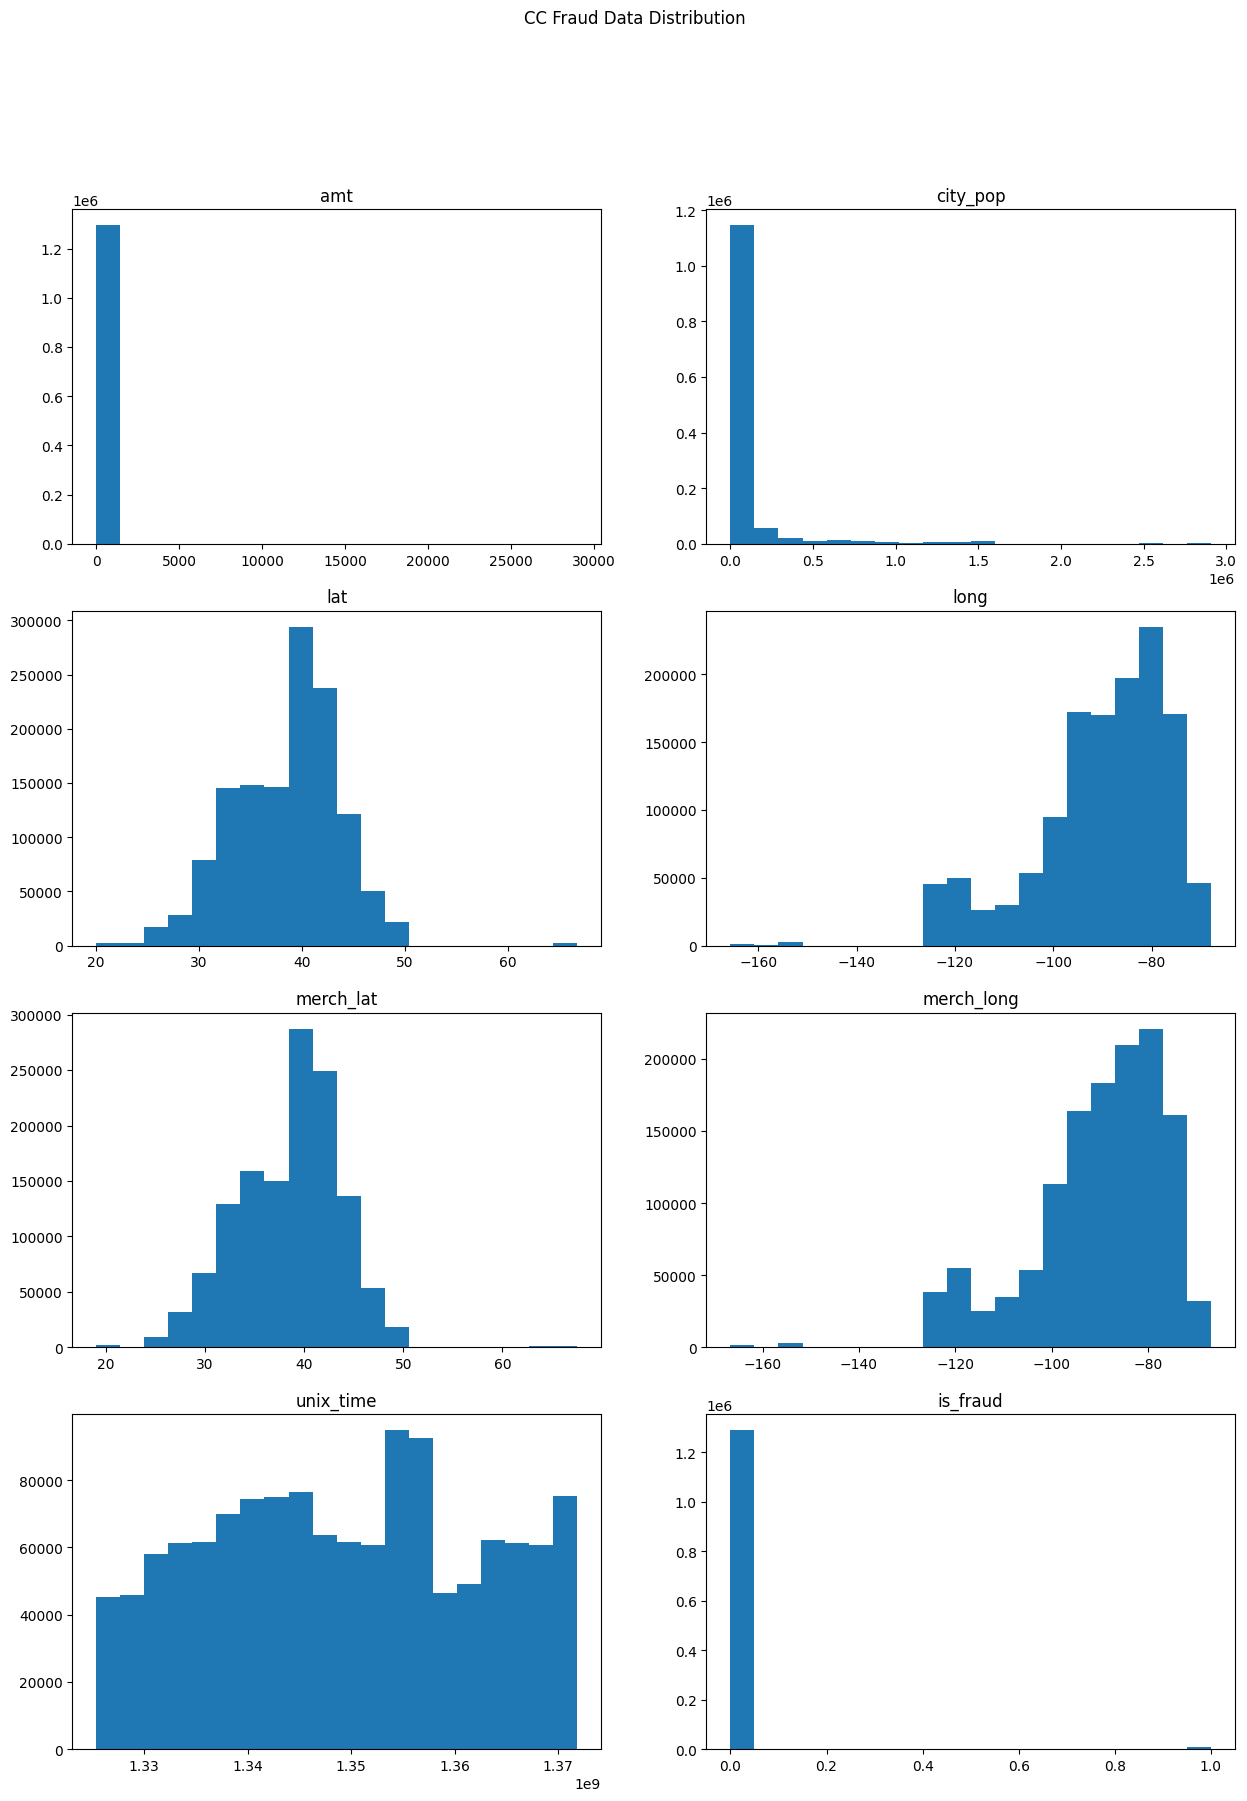

In [0]:
fig, axs = plt.subplots(4 , 2, figsize=(15, 20))
fig.suptitle('CC Fraud Data Distribution')

for idx, column in enumerate(['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time', 'is_fraud']):
    # Show histogram of the column
    bins, counts = cc.select(column).rdd.flatMap(lambda x: x).map(float).histogram(20)
    axs[idx//2][idx%2].set_title(column)
    axs[idx//2][idx%2].hist(bins[:-1], bins=bins, weights=counts)
    
plt.show()

In [0]:
cc.select("category").groupby("category").count().toPandas()

,category,count
0,travel,40507
1,misc_net,63287
2,grocery_pos,123638
3,kids_pets,113035
4,shopping_net,97543
5,grocery_net,45452
6,food_dining,91461
7,gas_transport,131659
8,personal_care,90758
9,health_fitness,85879


In [0]:
cc.select("gender").groupby("gender").count().toPandas()

,gender,count
0,F,709863
1,M,586812


### EDA Preliminary Findings

- The data appears to be clean with no missing values
- Some of the heavily skewed features like amt and city_pop may benefit from logarithmic transformation
- The target class (is_fraud) is heavily imbalanced

## Data Preparation

### Data Transformation

In [0]:
from pyspark.ml.feature import StringIndexer

# convert string categorical features to numeric indices
inputs = ['merchant', 'category', 'gender', 'city', 'state', 'job']
outputs = ['merchant_idx', 'category_idx', 'gender_idx', 'city_idx', 'state_idx', 'job_idx']
stringIndexer = StringIndexer(inputCols=inputs, outputCols=outputs)
model = stringIndexer.fit(cc)
cc_idx = model.transform(cc)

In [0]:
pd.DataFrame(cc_idx.take(10), columns=cc_idx.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merchant_idx,category_idx,gender_idx,city_idx,state_idx,job_idx
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,571.0,11.0,0.0,258.0,12.0,141.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,81.0,1.0,0.0,25.0,29.0,61.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,319.0,6.0,1.0,798.0,45.0,457.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,40.0,0.0,1.0,821.0,39.0,232.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,519.0,10.0,1.0,272.0,14.0,297.0
5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,Dublin,PA,18917,40.3750,-75.2045,2158.0,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.653382,-76.152667,0,9.0,0.0,0.0,653.0,2.0,240.0
6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.9931,-100.9893,2691.0,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.162705,-100.153370,0,622.0,12.0,0.0,196.0,25.0,148.0
7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,Edinburg,VA,22824,38.8432,-78.6003,6018.0,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.948089,-78.540296,0,21.0,0.0,1.0,505.0,14.0,373.0
8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,Manor,PA,15665,40.3359,-79.6607,1472.0,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.351813,-79.958146,0,498.0,10.0,0.0,621.0,2.0,291.0
9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040,36.5220,-87.3490,151785.0,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.179198,-87.485381,0,107.0,1.0,0.0,295.0,31.0,379.0


In [0]:
from pyspark.ml.feature import OneHotEncoder

# one-hot encode indexed categorical features
inputs_1hot = ['merchant_idx', 'category_idx', 'city_idx', 'state_idx', 'job_idx']
outputs_1hot = ['merchant_1hot', 'category_1hot', 'city_1hot', 'state_1hot', 'job_1hot']

oneHotEncoder = OneHotEncoder(inputCols=inputs_1hot, outputCols=outputs_1hot)
model_1hot = oneHotEncoder.fit(cc_idx)
cc_1hot = model_1hot.transform(cc_idx)

In [0]:
pd.DataFrame(cc_1hot.take(5), columns=cc_1hot.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merchant_idx,category_idx,gender_idx,city_idx,state_idx,job_idx,merchant_1hot,category_1hot,city_1hot,state_1hot,job_1hot
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,571.0,11.0,0.0,258.0,12.0,141.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,81.0,1.0,0.0,25.0,29.0,61.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,319.0,6.0,1.0,798.0,45.0,457.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,40.0,0.0,1.0,821.0,39.0,232.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,519.0,10.0,1.0,272.0,14.0,297.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [0]:
# apply logarithmic transformation to amt and cit_pop features
cc_prepped = cc_1hot.withColumn('amt_log', log(col("amt"))) \
                                .withColumn('city_pop_log', log(col("city_pop")))

In [0]:
pd.DataFrame(cc_prepped.take(5), columns=cc_prepped.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merchant_idx,category_idx,gender_idx,city_idx,state_idx,job_idx,merchant_1hot,category_1hot,city_1hot,state_1hot,job_1hot,amt_log,city_pop_log
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,571.0,11.0,0.0,258.0,12.0,141.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.603420,8.159089
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,81.0,1.0,0.0,25.0,29.0,61.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.674976,5.003946
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,319.0,6.0,1.0,798.0,45.0,457.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.394127,8.331827
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,40.0,0.0,1.0,821.0,39.0,232.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.806662,7.569928
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,519.0,10.0,1.0,272.0,14.0,297.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.736717,4.595120


### Review of Revised Distribution for Amt and City_Pop

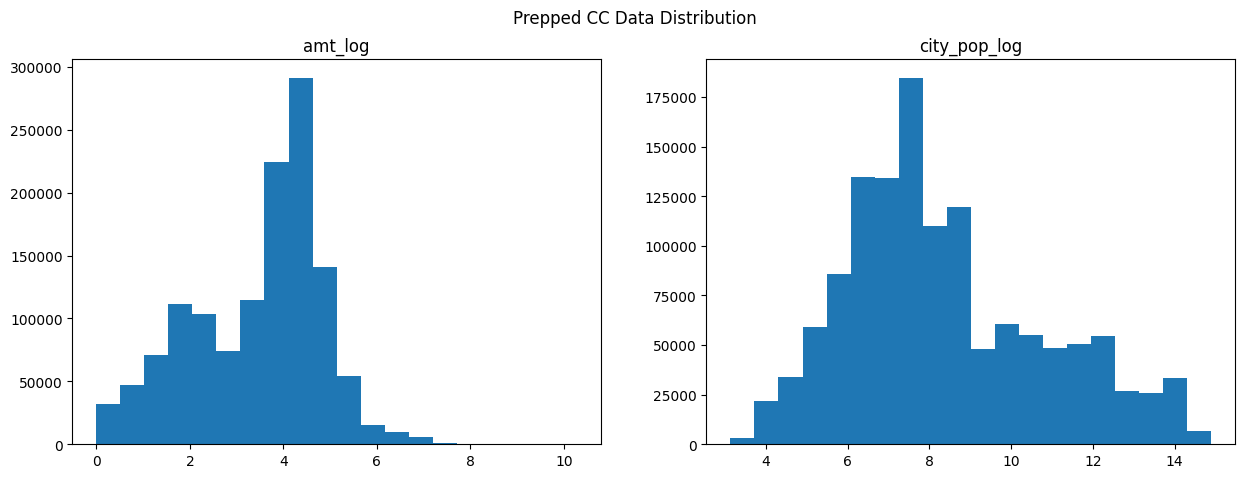

In [0]:
# plot revised data distribution
fig, axs = plt.subplots(1 , 2, figsize=(15, 5))
fig.suptitle('Prepped CC Data Distribution')

for idx, column in enumerate(['amt_log', 'city_pop_log']):
    # Show histogram of the column
    bins, counts = cc_prepped.select(column).rdd.flatMap(lambda x: x).map(float).histogram(20)
    axs[idx%2].set_title(column)
    axs[idx%2].hist(bins[:-1], bins=bins, weights=counts)
    
plt.show()

### Feature Extraction and Training/Test DataSet Creation

In [0]:
from pyspark.ml.feature import VectorAssembler

# assemble the prepped features into one single vector.
featureCols = ['amt_log', 'city_pop_log', 'job_1hot', 'state_1hot', 'category_1hot', 'gender_idx']
assembler = (VectorAssembler()
  .setInputCols(featureCols)
  .setOutputCol("features"))

cc_final = assembler.transform(cc_prepped)

In [0]:
# setup training and test datasets

training, test = cc_final.randomSplit([0.7, 0.3])

#  Not working with a dataset this size - Going to cache the data to make sure things stay snappy!
# training.cache()
# test.cache()

print(training.count())
print(test.count())

907811
388864


In [0]:
test.select("is_fraud").groupby("is_fraud").count().toPandas()

,is_fraud,count
0,1,2224
1,0,386640


## ML Training and Prediction - RandomForestClassifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="is_fraud", seed=42,
    leafCol="leafId")
rf.setFeaturesCol("features")

model = rf.fit(training)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
preds = model.transform(test) 

In [0]:
pd.DataFrame(preds.take(10), columns=preds.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merchant_idx,category_idx,gender_idx,city_idx,state_idx,job_idx,merchant_1hot,category_1hot,city_1hot,state_1hot,job_1hot,amt_log,city_pop_log,features,rawPrediction,probability,prediction,leafId
0,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,319.0,6.0,1.0,798.0,45.0,457.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.394127,8.331827,"(5.394127421394012, 8.331827004436057, 0.0, 0....","[2.9823647916053972, 0.017635208394602538]","[0.994121597201799, 0.005878402798200846]",0.0,"[1.0, 1.0, 2.0]"
1,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,40.0,0.0,1.0,821.0,39.0,232.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.806662,7.569928,"(3.8066624897703196, 7.569927655242652, 0.0, 0...","[2.9823647916053972, 0.017635208394602538]","[0.994121597201799, 0.005878402798200846]",0.0,"[1.0, 1.0, 2.0]"
2,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.9931,-100.9893,2691.0,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.162705,-100.153370,0,622.0,12.0,0.0,196.0,25.0,148.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.796388,7.897668,"(3.7963876618292214, 7.897668150726906, 0.0, 0...","[2.9823647916053972, 0.017635208394602538]","[0.994121597201799, 0.005878402798200846]",0.0,"[1.0, 1.0, 2.0]"
3,2019-01-01 00:06:53,377234009633447,fraud_Kerluke-Abshire,shopping_net,7.77,Theresa,Blackwell,F,43576 Kristina Islands,Shenandoah Junction,WV,25442,39.3716,-77.8229,1925.0,Systems developer,1966-02-14,3c74776e558f1499a7824b556e474b1d,1325376413,40.103866,-78.624459,0,371.0,5.0,0.0,266.0,22.0,6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",2.050270,7.562681,"(2.050270164379556, 7.562681246721884, 0.0, 0....","[2.9823647916053972, 0.017635208394602538]","[0.994121597201799, 0.005878402798200846]",0.0,"[1.0, 1.0, 2.0]"
4,2019-01-01 00:06:56,180042946491150,fraud_Lockman Ltd,grocery_pos,71.22,Charles,Robles,M,3337 Lisa Divide,Saint Petersburg,FL,33710,27.7898,-82.7243,341043.0,"Engineer, land",1989-02-28,c1d9a7ddb1e34639fe82758de97f4abf,1325376416,27.630593,-82.308891,0,88.0,1.0,1.0,254.0,7.0,179.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.265774,12.739764,"(4.265773677849632, 12.739763848022498, 0.0, 0...","[2.9823647916053972, 0.017635208394602538]","[0.9941215

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Instantiate the evaluator
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",
                                   labelCol="is_fraud", 
                                   metricName= "areaUnderROC")
                                   
bce.evaluate(preds)

0.5015922085422909

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

# create confusion matrix

preds_float = preds \
    .select("prediction", "is_fraud") \
    .withColumn("is_fraud", col("is_fraud").cast(DoubleType())) \
    .orderBy("prediction")

cm = MulticlassMetrics(preds_float.rdd.map(tuple))

# print(cm.confusionMatrix().toArray())

#show the confusion matrix as a pandas df for clearer presentation
pd.DataFrame(cm.confusionMatrix().toArray(),
             columns= ["true positive", "true negative"],
             index= ["predicted positive", "predicted negative"])

/databricks/spark/python/pyspark/sql/context.py:166: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,true positive,true negative
predicted positive,386640.0,0.0
predicted negative,2224.0,0.0


### Results Analysis

With a false negative rate of 100% in the confusion matrix, and 0.5 AUC score we obviously have work to do! ;-)